# Tensorflow time series for aiops

In [53]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [73]:
df = pd.read_csv('../../../cto_k8s/m_data_10.11.1.80:9091.csv', usecols=['time', 'cpu_value', 'memory_value'])
df.rename(columns={'cpu_value':'cpu', 'memory_value' : 'memory'}, inplace=True)

df['cpu'] = df['cpu'].fillna(df['cpu'].mean())
df['memory'] = df['memory'].fillna(df['memory'].mean())
df_ori = df[['time', 'cpu', 'memory']]   

df['Date Time'] = pd.to_datetime(df.time, unit='s')
df = df[['Date Time', 'cpu', 'memory']]
date_time = df.pop('Date Time')
df.head() 

,cpu,memory
0,0.565333,0.359691
1,0.571564,0.359799
2,0.543800,0.360392
3,0.534930,0.359795
4,0.569663,0.359930


In [55]:
df.tail()

,cpu,memory
3894,3.012313,0.531181
3895,2.939557,0.429435
3896,2.004364,0.534530
3897,1.458301,0.511703
3898,1.458301,0.510870


'\nday_of_data = 1*6*24   # start 8월 4일z\nplot_features_test = df[plot_cols][day_of_data*7:day_of_data*8]\nplot_features_test.index = date_time[day_of_data*7:day_of_data*8]\n_ = plot_features_test.plot(subplots = True)\n'

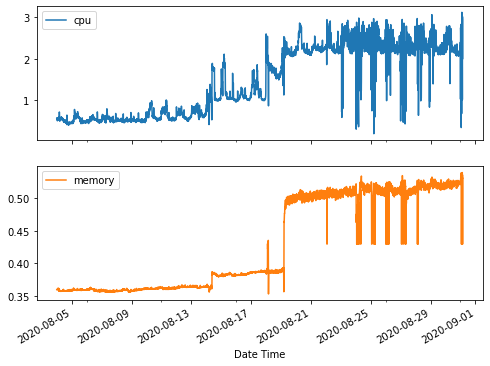

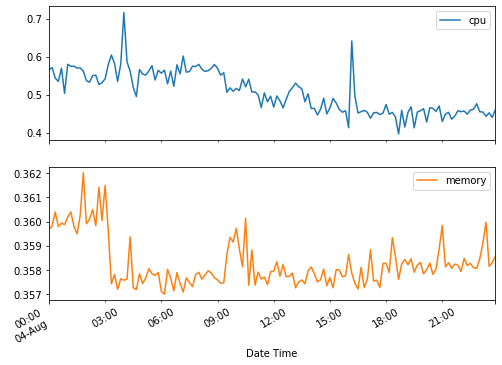

In [56]:
plot_cols = ['cpu', 'memory']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

plot_features = df[plot_cols][:144]
plot_features.index = date_time[:144]
_ = plot_features.plot(subplots = True)

'''
day_of_data = 1*6*24   # start 8월 4일z
plot_features_test = df[plot_cols][day_of_data*7:day_of_data*8]
plot_features_test.index = date_time[day_of_data*7:day_of_data*8]
_ = plot_features_test.plot(subplots = True)
'''

In [57]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cpu,3899.0,1.458301,0.815101,0.193111,0.586200,1.279000,2.230933,3.116267
memory,3899.0,0.429435,0.070820,0.353096,0.361021,0.386258,0.508112,0.539055


Text(0, 0.5, 'memory')

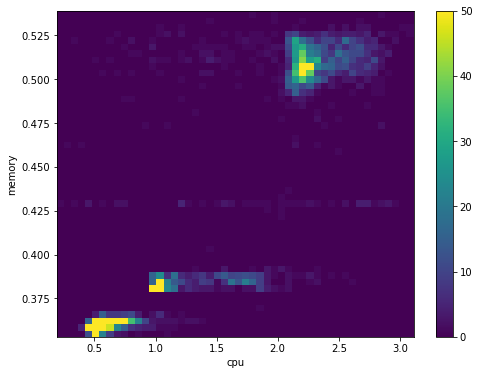

In [58]:
plt.hist2d(df['cpu'], df['memory'], bins=(50, 50), vmax=50)
plt.colorbar()
plt.xlabel('cpu')
plt.ylabel('memory')

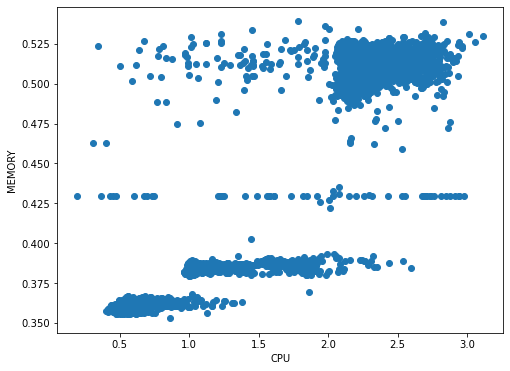

In [59]:
# 양의 상관관계 존재
df_scatter = df[['cpu', 'memory']]
plt.xlabel('CPU')
plt.ylabel('MEMORY')
plt.scatter(df_scatter['cpu'], df_scatter['memory'])

### 데이터 분할

In [76]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [77]:
df['Day sin'] = np.sin(df_ori['time'] * (2 * np.pi / day))
df['Day cos'] = np.cos(df_ori['time'] * (2 * np.pi / day)) 
df['Year sin'] = np.sin(df_ori['time'] * (2 * np.pi / day))
df['Year cos'] = np.cos(df_ori['time'] * (2 * np.pi / day))

Text(0.5, 1.0, 'Time of day signal')

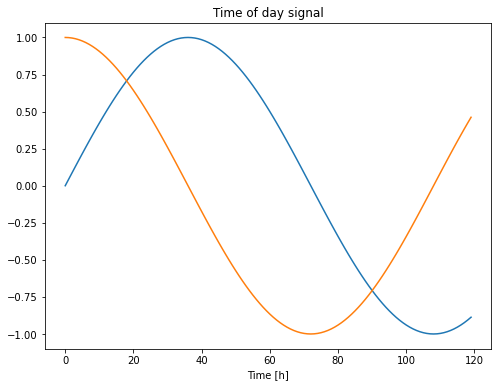

In [80]:
plt.plot(np.array(df['Day sin'])[:120])
plt.plot(np.array(df['Day cos'])[:120])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

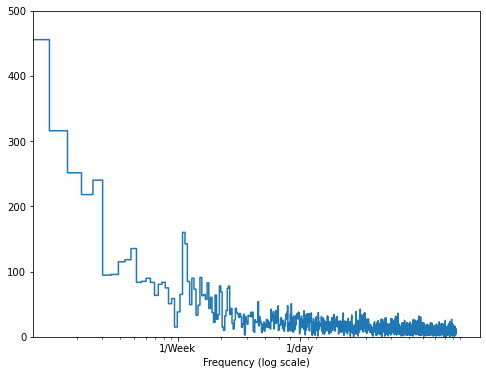

In [156]:
fft = tf.signal.rfft(df['cpu']) 
f_per_dataset = np.arange(0, len(fft)) 

n_samples_h = len(df['cpu']) 
hours_per_week = 24*7 
years_per_dataset = n_samples_h/(hours_per_week) 

f_per_year = f_per_dataset/years_per_dataset 
plt.step(f_per_year, np.abs(fft)) 
plt.xscale('log') 
plt.ylim(0, 500)
plt.xlim([0.1, max(plt.xlim())]) 
plt.xticks([1, 7], labels = ['1/Week', '1/day']) 
_ = plt.xlabel('Frequency (log scale)')

In [128]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)] 
val_df = df[int(n*0.7):int(n*0.9)] 
test_df = df[int(n*0.9):] 

num_features = df.shape[1]

In [129]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std 
val_df = (train_df - train_mean) / train_std 
test_df = (train_df - train_mean) / train_std 

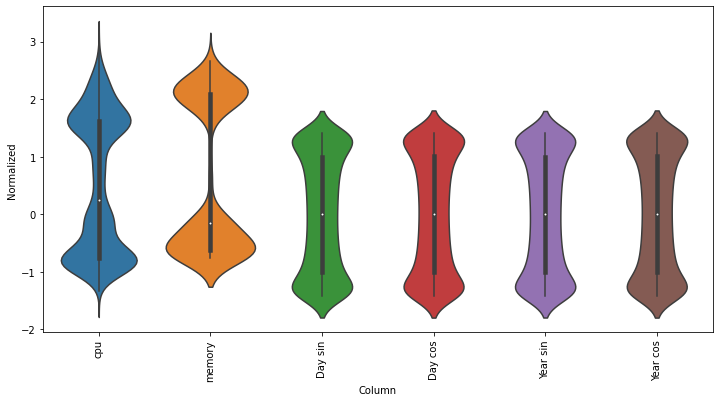

In [130]:
df_std = (df - train_mean) / train_std 
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized') 
plt.figure(figsize = (12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std) 
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [131]:
## 1. 인덱스 및 오프셋

In [172]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns 
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in 
                               enumerate(train_df.columns)}
            
        # Work out the window parameters. 
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift 
            
        self.total_window_size = input_width + shift 

        self.input_slice = slice(0, input_width) 
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
            
        self.label_start = self.total_window_size - self.label_width 
        self.labels_slice = slice(self.label_start, None) 
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] 
            
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}', 
            f'Input indices: {self.input_indices}', 
            f'Label indices: {self.label_indices}', 
            f'Label column name(s): {self.label_columns}'])

In [173]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, 
                     label_columns=['cpu', 'memory'])
w1 

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['cpu', 'memory']

In [174]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, 
                     label_columns=['cpu', 'memory']) 
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['cpu', 'memory']

In [175]:
## 2. 분할

In [176]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], 
            axis=-1)
    
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect. 
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window 

In [177]:
# Stack three slices, the length of the total window: 
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window) 

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 2)


In [178]:
## 3. 플롯 : 분할 창을 간단하게 시각화 

In [179]:
w2.example = example_inputs, example_labels 

In [188]:
def plot(self, model=None, plot_col='cpu', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8)) 
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue 
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

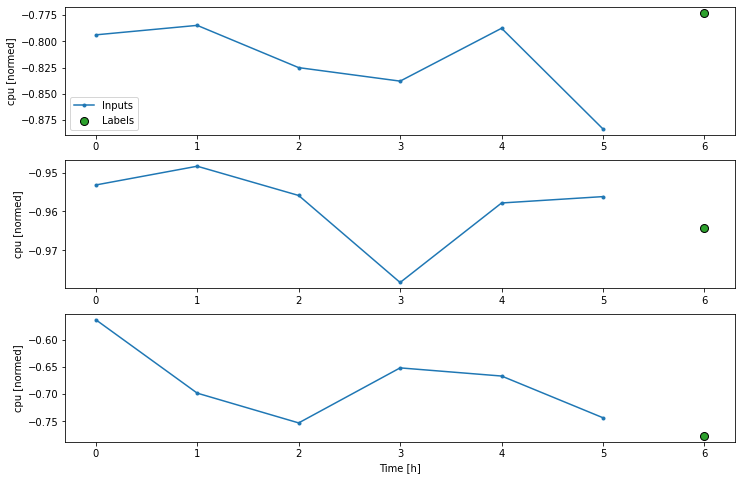

In [189]:
w2.plot()

In [144]:
## 4. tf.data.Dataset 생성

In [145]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [146]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of 'inputs, labels' for plotting. """
    result = getattr(self, '_example', None)
    if result is None:
        #No example batch was found, so get one from the '.train' dataset 
        result = next(iter(self.train)) 
        #And cache it for net time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example 

In [147]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [148]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


# 단일 단계 모델 

In [150]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['cpu'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['cpu']

In [151]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [152]:
## Baseline

In [153]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
      if self.label_index is None:
          return inputs
      result = inputs[:, :, self.label_index]
      return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['cpu'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)

In [ ]:
## Linear model

In [ ]:
linear = tf.keras.Sequential([ 
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(linear)

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
## Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
## Multi-step dense

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, 
    label_width=1, 
    shift=1, 
    label_columns=['T (degC)'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

In [ ]:
## 컨볼루션 신경망 (CNN)

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
## 순환 신경망 (RNN)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
## Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')